In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
COLORS=sns.color_palette()

%matplotlib inline

In [13]:
def plot_bar(df,xlabel,ylabel,title,figsize=(20,10),color=COLORS[-1],rotation=45):
    plot=df.plot(kind='bar',color=color,figsize=figsize)
    plot.set_xlabel(xlabel,fontsize=10)
    plot.set_ylabel(ylabel,fontsize=10)
    plot.set_title(title,fontsize=12)
    plot.set_xticklabels(labels=df.index,rotation=rotation)
    
    

In [5]:
dtypes={
    'UnitPrice':np.float32,
    'CustomerID':np.int32,
    'Quantity':np.int32
}
retail=pd.read_csv('./OnlineRetailClean.csv',dtype=dtypes)
retail['InvoiceDate']=pd.to_datetime(retail['InvoiceDate'],infer_datetime_format=True)
retail.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## 쿠폰발송 시 push를 언제 보내는 것이 좋을까

In [9]:
#각 시간별로 얼마나 많은 주문이 있는지 확인
order_by_hour=retail.set_index('InvoiceDate').groupby(lambda date:date.hour).count()['CustomerID']
order_by_hour

6         1
7       379
8      8690
9     21944
10    37997
11    49084
12    72065
13    64026
14    54118
15    45369
16    24089
17    13071
18     2928
19     3321
20      802
Name: CustomerID, dtype: int64

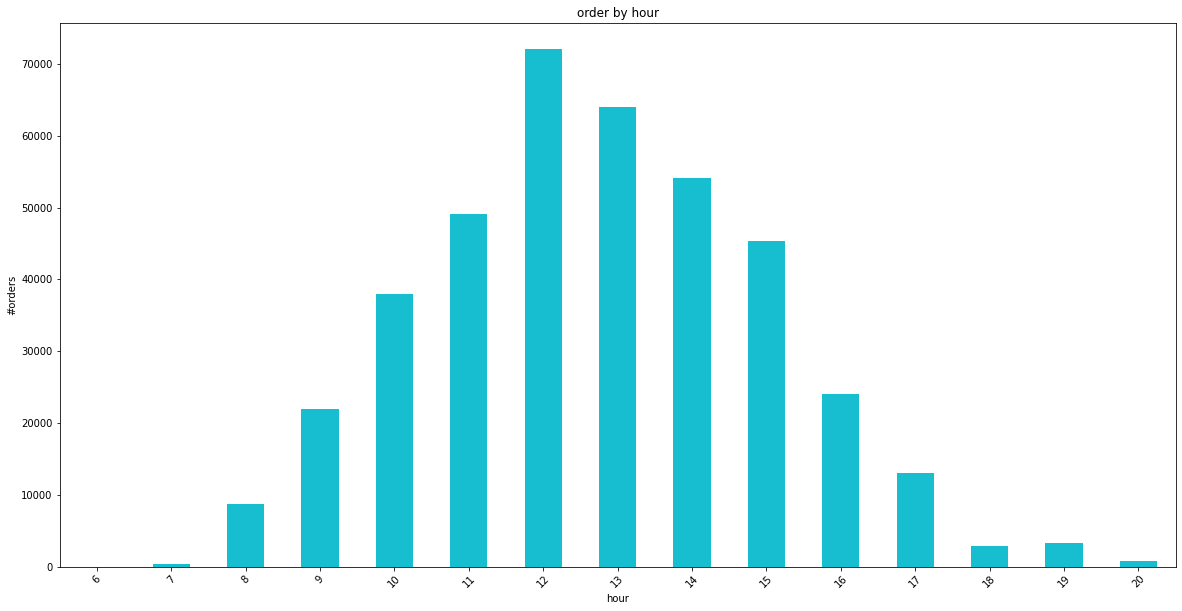

In [14]:
#딱봐도 가장 많아 보이는 시간대는 12시이다.
plot_bar(order_by_hour,'hour','#orders','order by hour')

In [15]:
#더세분화 해보겠다. 30분 단위로 더 끊어보자
def half_an_hour(date):
    minute=':00'
    if date.minute>30:
        minute=':30'
    hour=str(date.hour)
    if date.hour<10:
        hour='0'+hour
    return hour+minute

In [17]:
order_by_hour_half=retail.set_index('InvoiceDate').groupby(half_an_hour).count()['CustomerID']
order_by_hour_half

06:00        1
07:30      379
08:00     3145
08:30     5545
09:00     9364
09:30    12580
10:00    16950
10:30    21047
11:00    18925
11:30    30159
12:00    37174
12:30    34891
13:00    31131
13:30    32895
14:00    26958
14:30    27160
15:00    24227
15:30    21142
16:00    14316
16:30     9773
17:00     8889
17:30     4182
18:00     1715
18:30     1213
19:00     1534
19:30     1787
20:00      802
Name: CustomerID, dtype: int64

In [19]:
#비율 구하기
order_by_hour_half/order_by_hour_half.sum()

06:00    0.000003
07:30    0.000953
08:00    0.007904
08:30    0.013936
09:00    0.023534
09:30    0.031617
10:00    0.042600
10:30    0.052897
11:00    0.047564
11:30    0.075798
12:00    0.093429
12:30    0.087691
13:00    0.078241
13:30    0.082675
14:00    0.067753
14:30    0.068261
15:00    0.060890
15:30    0.053136
16:00    0.035980
16:30    0.024562
17:00    0.022341
17:30    0.010511
18:00    0.004310
18:30    0.003049
19:00    0.003855
19:30    0.004491
20:00    0.002016
Name: CustomerID, dtype: float64

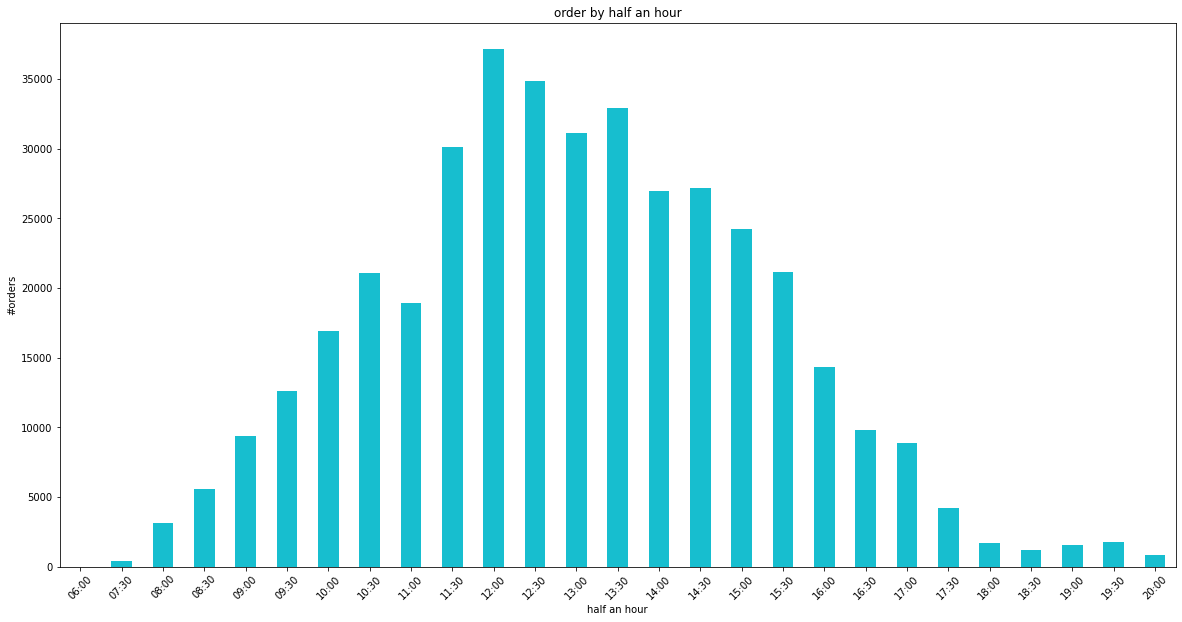

In [20]:
plot_bar(order_by_hour_half,'half an hour','#orders','order by half an hour')

### 개인화 된 push notification
- 개인 맞춤형 최적의 솔루션
- 사용자별로 소비 패턴이 다를 수 있기 때문에 가장 많이 구매한 시간대를 찾아 해당 시간대에 쿠폰 발송

In [25]:
# 사용자별 각 시간별 주문량 계산하기
order_count_by_hour=retail.set_index('InvoiceDate').groupby(['CustomerID',lambda date:date.hour]).count()['StockCode']
order_count_by_hour

CustomerID    
12346       10     1
12347       8     22
            10    24
            12    47
            13    18
                  ..
18283       15     1
            16    56
            19    87
18287       9      3
            10    67
Name: StockCode, Length: 11205, dtype: int64

12346번 고객은 10시에 1개
12347번 고객은 8시에 22개, 10시에 24개 12시에 47개 ... 로 구매를 했다.

In [23]:
order_count_by_hour.loc[12347]

8     22
10    24
12    47
13    18
14    60
15    11
Name: StockCode, dtype: int64

이 사람은 14시에 가장 많이 주문했다!

In [29]:
## 사용자별 최대 주문 시간 구하기
idx=order_count_by_hour.groupby('CustomerID').idxmax()
idx


CustomerID
12346    (12346, 10)
12347    (12347, 14)
12348    (12348, 19)
12349     (12349, 9)
12350    (12350, 16)
            ...     
18280     (18280, 9)
18281    (18281, 10)
18282    (18282, 13)
18283    (18283, 14)
18287    (18287, 10)
Name: StockCode, Length: 4338, dtype: object

In [32]:
#해당 시간 indexing
result=order_count_by_hour.loc[idx]
result

CustomerID    
12346       10      1
12347       14     60
12348       19     17
12349       9      73
12350       16     17
                 ... 
18280       9      10
18281       10      7
18282       13      7
18283       14    201
18287       10     67
Name: StockCode, Length: 4338, dtype: int64

In [33]:
#아이디, 구매최대시간, 최대가 되는 구매량
result.reset_index().groupby('level_1').groups

{7: [73, 269, 319, 344, 375, 893, 1667, 2317], 8: [46, 58, 87, 126, 172, 179, 187, 260, 278, 279, 282, 292, 306, 347, 399, 429, 496, 503, 526, 533, 549, 552, 651, 671, 747, 755, 784, 792, 800, 803, 806, 821, 838, 877, 883, 920, 944, 947, 951, 954, 1008, 1093, 1106, 1120, 1138, 1172, 1173, 1217, 1251, 1397, 1422, 1424, 1436, 1472, 1512, 1616, 1621, 1666, 1668, 1678, 1687, 1734, 1759, 1761, 1774, 1791, 1815, 1827, 1846, 1859, 1895, 1900, 1903, 1996, 2018, 2023, 2054, 2085, 2108, 2117, 2167, 2172, 2253, 2380, 2383, 2403, 2404, 2417, 2427, 2462, 2464, 2643, 2749, 2776, 2781, 2896, 2936, 2949, 3021, 3130, ...], 9: [3, 9, 26, 30, 33, 35, 37, 48, 60, 66, 75, 84, 86, 90, 100, 106, 107, 121, 127, 135, 138, 142, 144, 146, 154, 159, 181, 199, 230, 240, 264, 265, 267, 277, 280, 286, 294, 298, 328, 333, 336, 342, 343, 352, 362, 366, 385, 402, 421, 459, 470, 475, 478, 482, 483, 509, 517, 519, 574, 603, 615, 630, 636, 642, 644, 691, 701, 706, 707, 746, 749, 752, 764, 770, 781, 783, 818, 825, 829, 844